In [57]:
import numpy as np
import cv2
import pywt
from PIL import Image, ImageFilter
import random
import math
import cmath
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import time
import os
import statistics
import urllib.request
import threading
from scipy import ndimage

In [58]:
def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    #return (data-mean_data)/(std_data*np.sqrt(data.size-1))
    return (data-mean_data)/(std_data)
    
def normxcorr2(template, image, mode="full"):
    if np.ndim(template) > np.ndim(image) or \
            len([i for i in range(np.ndim(template)) if template.shape[i] > image.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    
    return out

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

class Attack:
    @staticmethod
    def blur(img: np.ndarray):
        return cv2.blur(img, (2, 2))

    @staticmethod
    def rotate180(img: np.ndarray):
        img = img.copy()
        angle = 180
        scale = 1.0
        w = img.shape[1]
        h = img.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        return cv2.warpAffine(img, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)

    @staticmethod
    def rotate90(img: np.ndarray):
        img = img.copy()
        angle = 90
        scale = 1.0
        w = img.shape[1]
        h = img.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        return cv2.warpAffine(img, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)

    @staticmethod
    def chop5(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        return img[int(w * 0.05):, :]

    @staticmethod
    def chop10(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        return img[int(w * 0.1):, :]

    @staticmethod
    def chop30(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        return img[int(w * 0.3):, :]

    @staticmethod
    def gray(img: np.ndarray):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return gray

    @staticmethod
    def saltnoise(img: np.ndarray):
        img = img.copy()
        for k in range(1000):
            i = int(np.random.random() * img.shape[1])
            j = int(np.random.random() * img.shape[0])
            if img.ndim == 2:
                img[j, i] = 255
            elif img.ndim == 3:
                img[j, i, 0] = 255
                img[j, i, 1] = 255
                img[j, i, 2] = 255
        return img

    @staticmethod
    def randline(img: np.ndarray):
        img = img.copy()
        cv2.rectangle(img, (384, 0), (510, 128), (0, 255, 0), 3)
        cv2.rectangle(img, (0, 0), (300, 128), (255, 0, 0), 3)
        cv2.line(img, (0, 0), (511, 511), (255, 0, 0), 5)
        cv2.line(img, (0, 511), (511, 0), (255, 0, 255), 5)
        return img

    @staticmethod
    def cover(img: np.ndarray):
        img = img.copy()
        cv2.circle(img, (256, 256), 63, (0, 0, 255), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Just DO it ', (10, 500), font, 4, (255, 255, 0), 2)
        return img

    @staticmethod
    def brighter10(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        for xi in range(0, w):
            for xj in range(0, h):
                img[xi, xj, 0] = int(img[xi, xj, 0] * 1.1)
                img[xi, xj, 1] = int(img[xi, xj, 1] * 1.1)
                img[xi, xj, 2] = int(img[xi, xj, 2] * 1.1)
        return img

    @staticmethod
    def darker10(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        for xi in range(0, w):
            for xj in range(0, h):
                img[xi, xj, 0] = int(img[xi, xj, 0] * 0.9)
                img[xi, xj, 1] = int(img[xi, xj, 1] * 0.9)
                img[xi, xj, 2] = int(img[xi, xj, 2] * 0.9)
        return img

    @staticmethod
    def largersize(img: np.ndarray):
        w, h = img.shape[:2]
        return cv2.resize(img, (int(h * 1.5), w))

    @staticmethod
    def smallersize(img: np.ndarray):
        w, h = img.shape[:2]
        return cv2.resize(img, (int(h * 0.5), w))

In [59]:
sdl = []
class PBIL1(object):
    def __init__(self,original_image,Image_after_idct,n=5,m=5,adaptive=False,iterations=100,lr=0.2,ms=0.05,range=1):
        self.PV=np.full((1,m),0.5)
        self.n=n
        self.m=m
        self.imgMAT = original_image ## np.random.uniform(low=0.0, high=255.0,size=(n,m)) #Should be given through constructor
        self.pop = np.random.choice(2,self.n*self.m,self.PV.tolist()).reshape(self.n,self.m)
        self.TimgMAT = Image_after_idct #np.random.uniform(low=0, high=0,size=(n,m)) #given imgMAT to be TRUNC 
        self.fitness= np.zeros(self.n)
        self.best_chromosome_index= -1
        self.best_chromosome_list = np.array
        self.best_chromosome_lists = []
        self.LR= lr
        self.MS= ms
        self.range = range
        self.sd=[]
        self.adaptive=adaptive
        self.iterations=iterations

    def adaptive_lr(self,i,j):                                                  ## Adaptive Learning Rate
        self.LR=self.LR*(i/j)
    
    def printData(self):
        print('Probability_vector=\n',self.PV)
        print('Population=\n',self.pop)
        print('Image=\n',self.imgMAT)
        print('Translated/Truncated Image=\n',self.TimgMAT)
        print('fitness=\n',self.fitness,end="\n")
        print('Best Chromosomes possible = ',self.best_chromosome_list)

    def translateImg(self):                                                     ## Translating Images
        # print(self.pop)
        for i in range(self.n):
            for j in range(self.m):
                if self.pop[i][j]==1:
                    # print(self.TimgMAT[i][j])
                    self.TimgMAT[i][j] = np.round((self.imgMAT[i][j]))+1
                else:
                    self.TimgMAT[i][j] = np.round((self.imgMAT[i][j]))
    
    def calculate_fitness(self):                                                ## Fitness Calculation
        self.fitness=np.zeros(self.n) # resetting fitness matrix to zero
        for i in range(self.n):
            for j in range(self.m):
                self.fitness[i]+=abs(self.TimgMAT[i][j] - self.imgMAT[i][j])
        self.best_chromosome_index = np.where(self.fitness == np.amin(self.fitness))
        self.best_chromosome_list=[i for i in self.pop[self.best_chromosome_index[0]].tolist()]
        
        for j in range(-self.range,self.range):
          for k in np.where(self.fitness == (np.amin(self.fitness)+j)):
            for i in k:
              self.best_chromosome_lists.append(self.pop[i].tolist())
        # print('Best Chromosomes list = \n',self.best_chromosome_lists)

        # print('Best Chromosomes possible = ',self.best_chromosome_list)
    
    def update_PV(self):                                                        ## Updating Probability vector
        Solution_Vector = np.zeros(len(self.best_chromosome_list[0]))
        for i in self.best_chromosome_lists:
          for j in range(len(i)):
            Solution_Vector[j] += (i[j] * 1/len(self.best_chromosome_lists))
       
        for i in range(len(self.PV)):
            self.PV[i]=self.PV[i]*(1-self.LR)+Solution_Vector[i]*self.LR
#         print('updated PV',self.PV)
        
    def mutate_PV(self):                                                        ## Mutating Probability Vector
        for i in range(len(self.PV)):
            self.PV[i]=self.PV[i]*(1-self.MS)+random.randint(0, 1)*self.LR
#         print('mutated PV',self.PV)

    def run(self):
        j=1
        while(True):
            j = j+1
            if j==self.iterations+1:
                sdl.append(self.sd)
                return self.TimgMAT
            if self.adaptive:    
                self.adaptive_lr(j,self.iterations+1)
            self.pop= np.random.choice(2,self.n*self.m,self.PV.tolist()).reshape(self.n,self.m)
            self.translateImg()
            self.calculate_fitness()
            self.update_PV()
            self.mutate_PV()
            BC=self.best_chromosome_list
            # self.printData()
            tmp=statistics.stdev(self.fitness.tolist())
            # print(self.fitness.tolist())
            self.sd.append(tmp)
            # print('Iteration',j,'\n Fitness Value=',tmp)
            # print()
            if len(BC)==self.n and np.amin(self.fitness)<=0:
                return self.TimgMAT

Water Mark


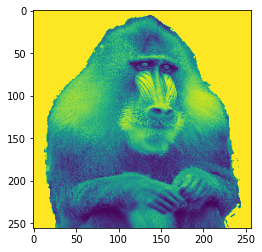

Image


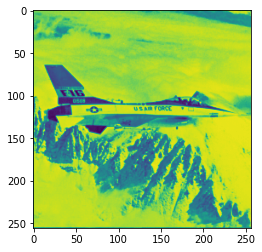

Before Attacked watermarked


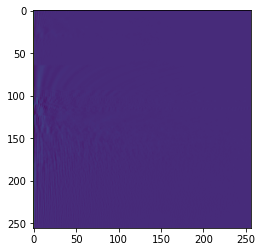

Attacked watermarked


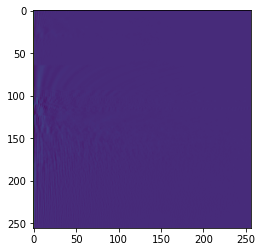

matrix after PBIL 



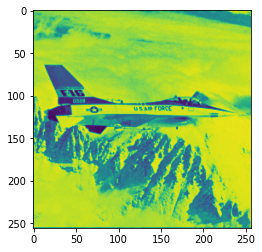

original watermark


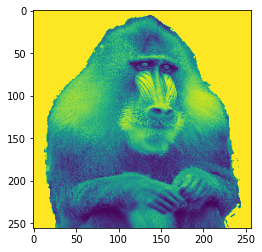

extracted watermark


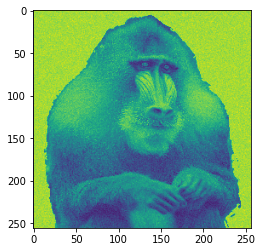

WaterMark PSNR,NCC: 22.275259022646125
0.9708045290737358
Host PSNR,NCC: 51.13593772870702
0.9999396046451545


In [60]:
Watermark_url = 'https://i.ibb.co/kQKsYPg/mandril.png'                          ## the image on the web
Watermark_url_save_name = '/content/mandril.png'                                ## local name to be saved
urllib.request.urlretrieve(Watermark_url, Watermark_url_save_name)

Host_image_url = 'https://i.ibb.co/ZGc6djH/airplane.png'                        ## the image on the web
Host_image_url_save_name = '/content/airplane.png'                              ## local name to be saved
urllib.request.urlretrieve(Host_image_url, Host_image_url_save_name)

watermark = cv2.imread('/content/mandril.png', 0)                               ## Reading Images 
host = cv2.imread('/content/airplane.png', 0)

N,M=256,256
P,Q=256,256

a = cv2.resize(host,(N,M))                                                      ## Resizing the images
b = cv2.resize(watermark,(P,Q)) 


print('Water Mark')
plt.imshow(b)
plt.show()

print('Image')
plt.imshow(a)
plt.show()

d=dct(a)                                                                        ## Applying DCT
c=d

for i in range(0,P):                                                            ## Hiding image to upper left corner
  for j in range(0,Q):
    c[i][j]+=b[i][j]
                                                             
cv2.imwrite("/content/BeforeAttackedwatermarked.png", c)

print('Before Attacked watermarked')
plt.imshow(c)
plt.show()

################################################################################  ## applying Attack

img = c ## No attack

##Uncomment for @BLURAttack
# img = Attack.blur(img)


## Uncomment for @RotateAttack
# img = Attack.rotate90(img)

## Uncomment for @CHOP30
# img = Attack.chop30(img)
# b = Attack.chop30(b)
# d = Attack.chop30(d)
# a = Attack.chop30(a)


## Uncomment for @saltnoise
# img= Attack.saltnoise(img)

################################################################################

cv2.imwrite("/content/Attackedwatermarked.png", img)

print('Attacked watermarked')
plt.imshow(img)
plt.show()

e=idct(img)                                                                     ## applying IDCT

# print('Original matrix \n',a)
# print('DCT Original matrix \n',d)
# print('IDCT Original matrix\n',e)

N,M = len(e),len(e[0])

g = PBIL1(a,e,N,M,True,100)                                                     ## PBIL + Adaptive Learning Rate      
# g = PBIL1(a,e,N,M,False,100)                                                  ## Static Learning Rate

afterimg = g.run()

print('matrix after PBIL \n')
plt.imshow(afterimg)
plt.show()

tmp = dct(afterimg)                                                             ## Extraction process starts here

cv2.imwrite("/content/ImageAfterPBIL.png", afterimg)

diff=d-tmp

# print('WaterMark\n',b)
# print(diff)

print('original watermark')
plt.imshow(b)
plt.show()

print('extracted watermark')
plt.imshow(diff)
plt.show()
cv2.imwrite("/content/Extractedwatermarked.png", diff)

print('WaterMark PSNR,NCC:',calculate_psnr(b,diff))                             ## Calculation of PSNR and normxcorr
h=normxcorr2(b,diff)
print((1.0/(b.size-1)) * np.sum(norm_data(b)*norm_data(diff)))
# plt.imshow(h)
# plt.show()

print('Host PSNR,NCC:',calculate_psnr(a,afterimg))
t=normxcorr2(a,afterimg)
print((1.0/(a.size-1)) * np.sum(norm_data(a)*norm_data(afterimg)))

# plt.imshow(t)
# plt.show()

## Stats
# print(sdl)
# x=[i for i in range(1,500)]
# plt.plot(x, np.array(sdl[0]), label = "Adaptive")
# plt.plot(x, np.array(sdl[1]), label = "Static")
# plt.legend()
# plt.show()